In [1]:
import aimBotEnv
import PPO
import numpy as np

import tensorflow as tf
import time
import datetime

from PPO import PPO
from PPOBuffer import PPOBuffer
from PPOConfig import PPOConfig
from PPOHistoryRecorder import PPOHistory
from IPython.display import clear_output

In [2]:
# Attempts to allocate only the GPU memory needed for allocation
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.random.set_seed(9331)

In [3]:
# Env
ENV_PATH = "./Build-CloseEnemyCut/Aimbot-PPO"
WORKER_ID = 1
BASE_PORT = 200

MAX_EP = 1000
EP_LENGTH = 100000
BATCH = 256  # learning step
ACTION_INTERVAL = 1  # take action every ACTION_INTERVAL steps


TRAIN = True
SAVE_DIR = "PPO-Model/" + datetime.datetime.now().strftime("%m%d%H%M") + "/"
LOAD_DIR = None

CTN_ACTION_RANGE = 10

ppoConfig = PPOConfig(
    NNShape=[512, 512],
    actorLR=2e-3,
    criticLR=2e-3,
    gamma=0.99,
    lmbda=0.95,
    clipRange=0.20,
    entropyWeight=1e-2,
    trainEpochs=5,
    saveDir="PPO-Model/" + datetime.datetime.now().strftime("%m%d-%H%M") + "/",
    loadModelDir=None,
)


In [4]:
# initialize enviroment & buffer class
env = aimBotEnv.makeEnv(envPath=ENV_PATH, workerID=WORKER_ID, basePort=BASE_PORT)
ppoBuffer = PPOBuffer()
ppoHistory = PPOHistory()

STATE_SIZE = env.STATE_SIZE
DISCRETE_SHAPE = env.DISCRETE_SHAPE
DISCRETE_SIZE = env.DISCRETE_SIZE
CONTINUOUS_SIZE = env.CONTINUOUS_SIZE
ACTSPEC = env.ACTION_SPEC
_, _, _, loadDir, _ = env.getSteps()

agent = PPO(
    stateSize=STATE_SIZE,
    disActShape=DISCRETE_SHAPE,
    conActSize=CONTINUOUS_SIZE,
    conActRange=CTN_ACTION_RANGE,
    PPOConfig=ppoConfig,
)

# check load model or not
if np.any(loadDir == 0):
    # create a new model
    print("No loadDir specified,Create a New Model")
    LOAD_DIR = None
else:
    # load model
    loadDirDateSTR = str(int(loadDir[0]))
    loadDirTimeSTR = str(int(loadDir[1]))
    if len(loadDirDateSTR) != 8:
        # fill lost 0 while converse float to string
        for _ in range(8 - len(loadDirDateSTR)):
            loadDirDateSTR = "0" + loadDirDateSTR
    if len(loadDirTimeSTR) != 6:
        # fill lost 0 while converse float to string
        for _ in range(6 - len(loadDirTimeSTR)):
            loadDirTimeSTR = "0" + loadDirTimeSTR
    LOAD_DIR = "PPO-Model/" + loadDirDateSTR + "/" + loadDirTimeSTR
    print("Load Model:")
    print(LOAD_DIR)

print("CONTINUOUS_SIZE", CONTINUOUS_SIZE)
print("DISCRETE_SIZE", DISCRETE_SIZE)
print("STATE_SIZE", STATE_SIZE)

disActShape = [3, 3, 2]


√√√√√Enviroment Initialized Success√√√√√
√√√√√Buffer Initialized Success√√√√√
---------thisPPO Params---------
self.stateSize =  31
self.disActShape =  [3, 3, 2]
self.disActSize 3
self.disOutputSize 8
self.conActSize =  1
self.conActRange =  10
self.conOutputSize =  2
---------thisPPO config---------
self.NNShape =  [512, 512, 256]
self.criticLR =  0.002
self.actorLR =  0.002
self.gamma =  0.99
self.lmbda =  0.95
self.clipRange =  0.2
self.entropyWeight =  0.01
self.trainEpochs =  5
self.saveDir =  GAIL-Model/1023-2324/
self.loadModelDir =  None
---------Actor Model Create Success---------
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stateInput (InputLayer)        [(None, 31)]         0           []                               
                                                                                         

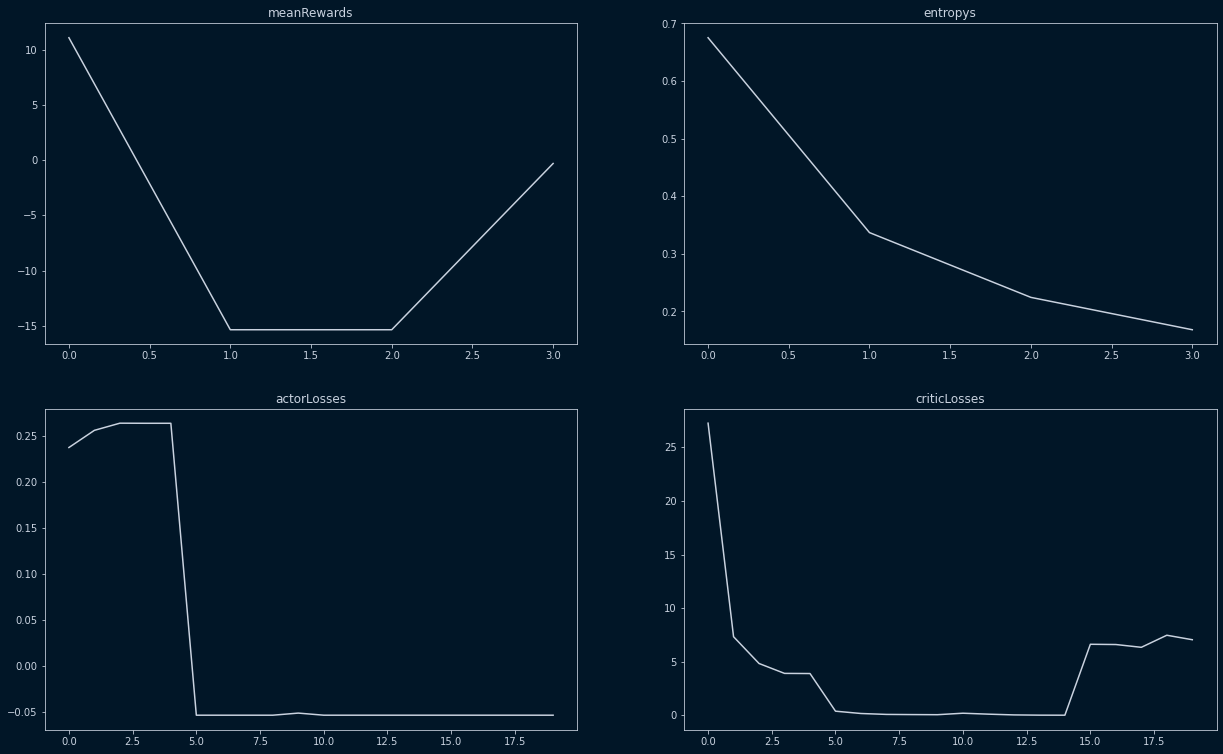

In [5]:
bestScore = 200.0

maxTotalReward = -99999999999

for ep in range(MAX_EP):
    print("EP ", ep, " START")
    # first time run game
    s, _, _, _, _ = env.reset()
    if ep == 0:
        s = s.reshape([STATE_SIZE])
    step = 0
    done = False

    # save weight immediately?
    saveNow = 0

    epTotalReward = 0
    entropys = []

    while not done:
        step += 1

        actions, predictResult = agent.chooseAction(s)
        avrEntropy, _, _ = agent.getAverageEntropy(predictResult)
        nextState, thisReward, done, _, saveNow = env.step(actions=actions)

        entropys.append(avrEntropy)
        ppoBuffer.saveBuffers(
            state=s, actorProb=predictResult, action=actions, reward=thisReward, done=done
        )
        epTotalReward += thisReward

        nextState = nextState.reshape([STATE_SIZE])
        s = nextState

        if done:
            print("EP OVER!")
        if saveNow != 0:
            print("SAVENOW!")
            saveNow = 0
            agent.saveWeights()
        # update PPO after Batch step or GameOver
        if (step + 1) % BATCH == 0 or done:
            if TRAIN:
                actorLosses, criticLosses = agent.trainCritcActor(
                    states=ppoBuffer.getStates(),
                    oldActorResult=ppoBuffer.getActorProbs(),
                    actions=ppoBuffer.getActions(),
                    rewards=ppoBuffer.getRewards(),
                    dones=ppoBuffer.getDones(),
                    nextState=nextState,
                )
                clear_output()
                ppoBuffer.clearBuffer()
                ppoHistory.saveHis(epTotalReward, np.mean(entropys), actorLosses, criticLosses)
                ppoHistory.drawHis()
            if epTotalReward > maxTotalReward and epTotalReward != 0:
                maxTotalReward = epTotalReward
                agent.saveWeights(epTotalReward)
                print("New Record! Save NN", epTotalReward)
            epTotalReward = 0
